# Description
For each density bin, plot the measured multipoles as well as the fitted Kaiser model with and without a FoG term.

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import legendre, erf
import time

import inv_cov_funcs as icf
import cat_power_algos as catpk
import classylss
import fitsio
from nbodykit.lab import *
from nbodykit import style
plt.style.use(style.notebook)

In [3]:
LOS = [0,0,1]
redshift = 0
BoxSize = 2000
cosmo_paras = classylss.load_ini('/home/jwack/main/Planck18_LCDM.ini')
cosmo = cosmology.cosmology.Cosmology.from_dict(cosmo_paras)
Plin = cosmology.LinearPower(cosmo, redshift, transfer='CLASS')

dk = 0.01
ells = [0,2]

/home/jwack/.conda/envs/nbodykit-env/lib/python3.8/site-packages/nbodykit/cosmology/cosmology.py:427: UserWarning: Class did not read input parameter(s): sigma_8
  self.engine = ClassEngine(pars)


In [59]:
# load data multipoles
k_full, shotnoise, n_ptile, Pk_ells_full = icf.load_power_data('/home/jwack/main/fitmodel_densitysplit/', 
                                                               ells, get_data_Pkmus=False)
# for given BoxSize, k is NaN above 0.034 and ignore first k bin
possible_kmax = k_full[k_full<=0.343][1:]
# set kmax up to which parameters have been fitted and slice data quantaties
kmax = possible_kmax[21] 
mask = np.full(len(k_full), False)
mask = k_full <= kmax
mask[0] = False 
k = k_full[mask]
Pk_ells = Pk_ells_full[:,:,mask]

# load fitted parameter values
b1 = np.loadtxt("fit_results/NoFoG/b1_fits.txt")
beta = np.loadtxt("fit_results/NoFoG/beta_fits.txt")

b1_damped = np.loadtxt("fit_results/FoG_largesigma/b1_fits.txt")
beta_damped = np.loadtxt("fit_results/FoG_largesigma/beta_fits.txt")
sigma_damped = np.loadtxt("fit_results/FoG_largesigma/sigma_fits.txt")

In [6]:
def Kaiser(theta):
    '''Analytic expression for monopole and quadrupole for pure Kaiser model'''
    b1, beta = theta
    model_multipoles = np.empty((len(ells), len(k)))
    model_multipoles[0] = (1 + 2/3*beta + 1/5*beta**2) * b1**2 * Plin(k)
    model_multipoles[1] = (4/3*beta + 4/7*beta**2) * b1**2 * Plin(k)
    
    return model_multipoles
    

def Kaiser_damped(theta):
    '''Analytic expression for monopole and quadrupole for Kaiser model damped by Gaussian FoG'''
    b1, beta, sigma = theta
    model_multipoles = np.empty((len(ells), len(k)))
    model_multipoles[0] = ( 1/(2*(k*sigma)**5) * (np.sqrt(2*np.pi)*erf(k*sigma/np.sqrt(2))*(3*beta**2+(k*sigma)**4+2*beta*(k*sigma)**2) + 
                                                np.exp(-0.5*(k*sigma)**2)*(-2*beta*(beta+2)*(k*sigma)**3-6*beta**2*k*sigma) ) ) * b1**2 * Plin(k)
    model_multipoles[1] = ( -5/(4*(k*sigma)**7) * (np.sqrt(2*np.pi)*erf(k*sigma/np.sqrt(2))*(-45*beta**2+(k*sigma)**6+(2*beta-3)*(k*sigma)**4+3*(beta-6)*beta*(k*sigma)**2) + 
                                                np.exp(-0.5*(k*sigma)**2)*((4*beta*(beta+2)+6)*(k*sigma)**5+12*beta*(2*beta+3)*(k*sigma)**3+90*beta**2*k*sigma) ) ) * b1**2 * Plin(k)
    
    return model_multipoles

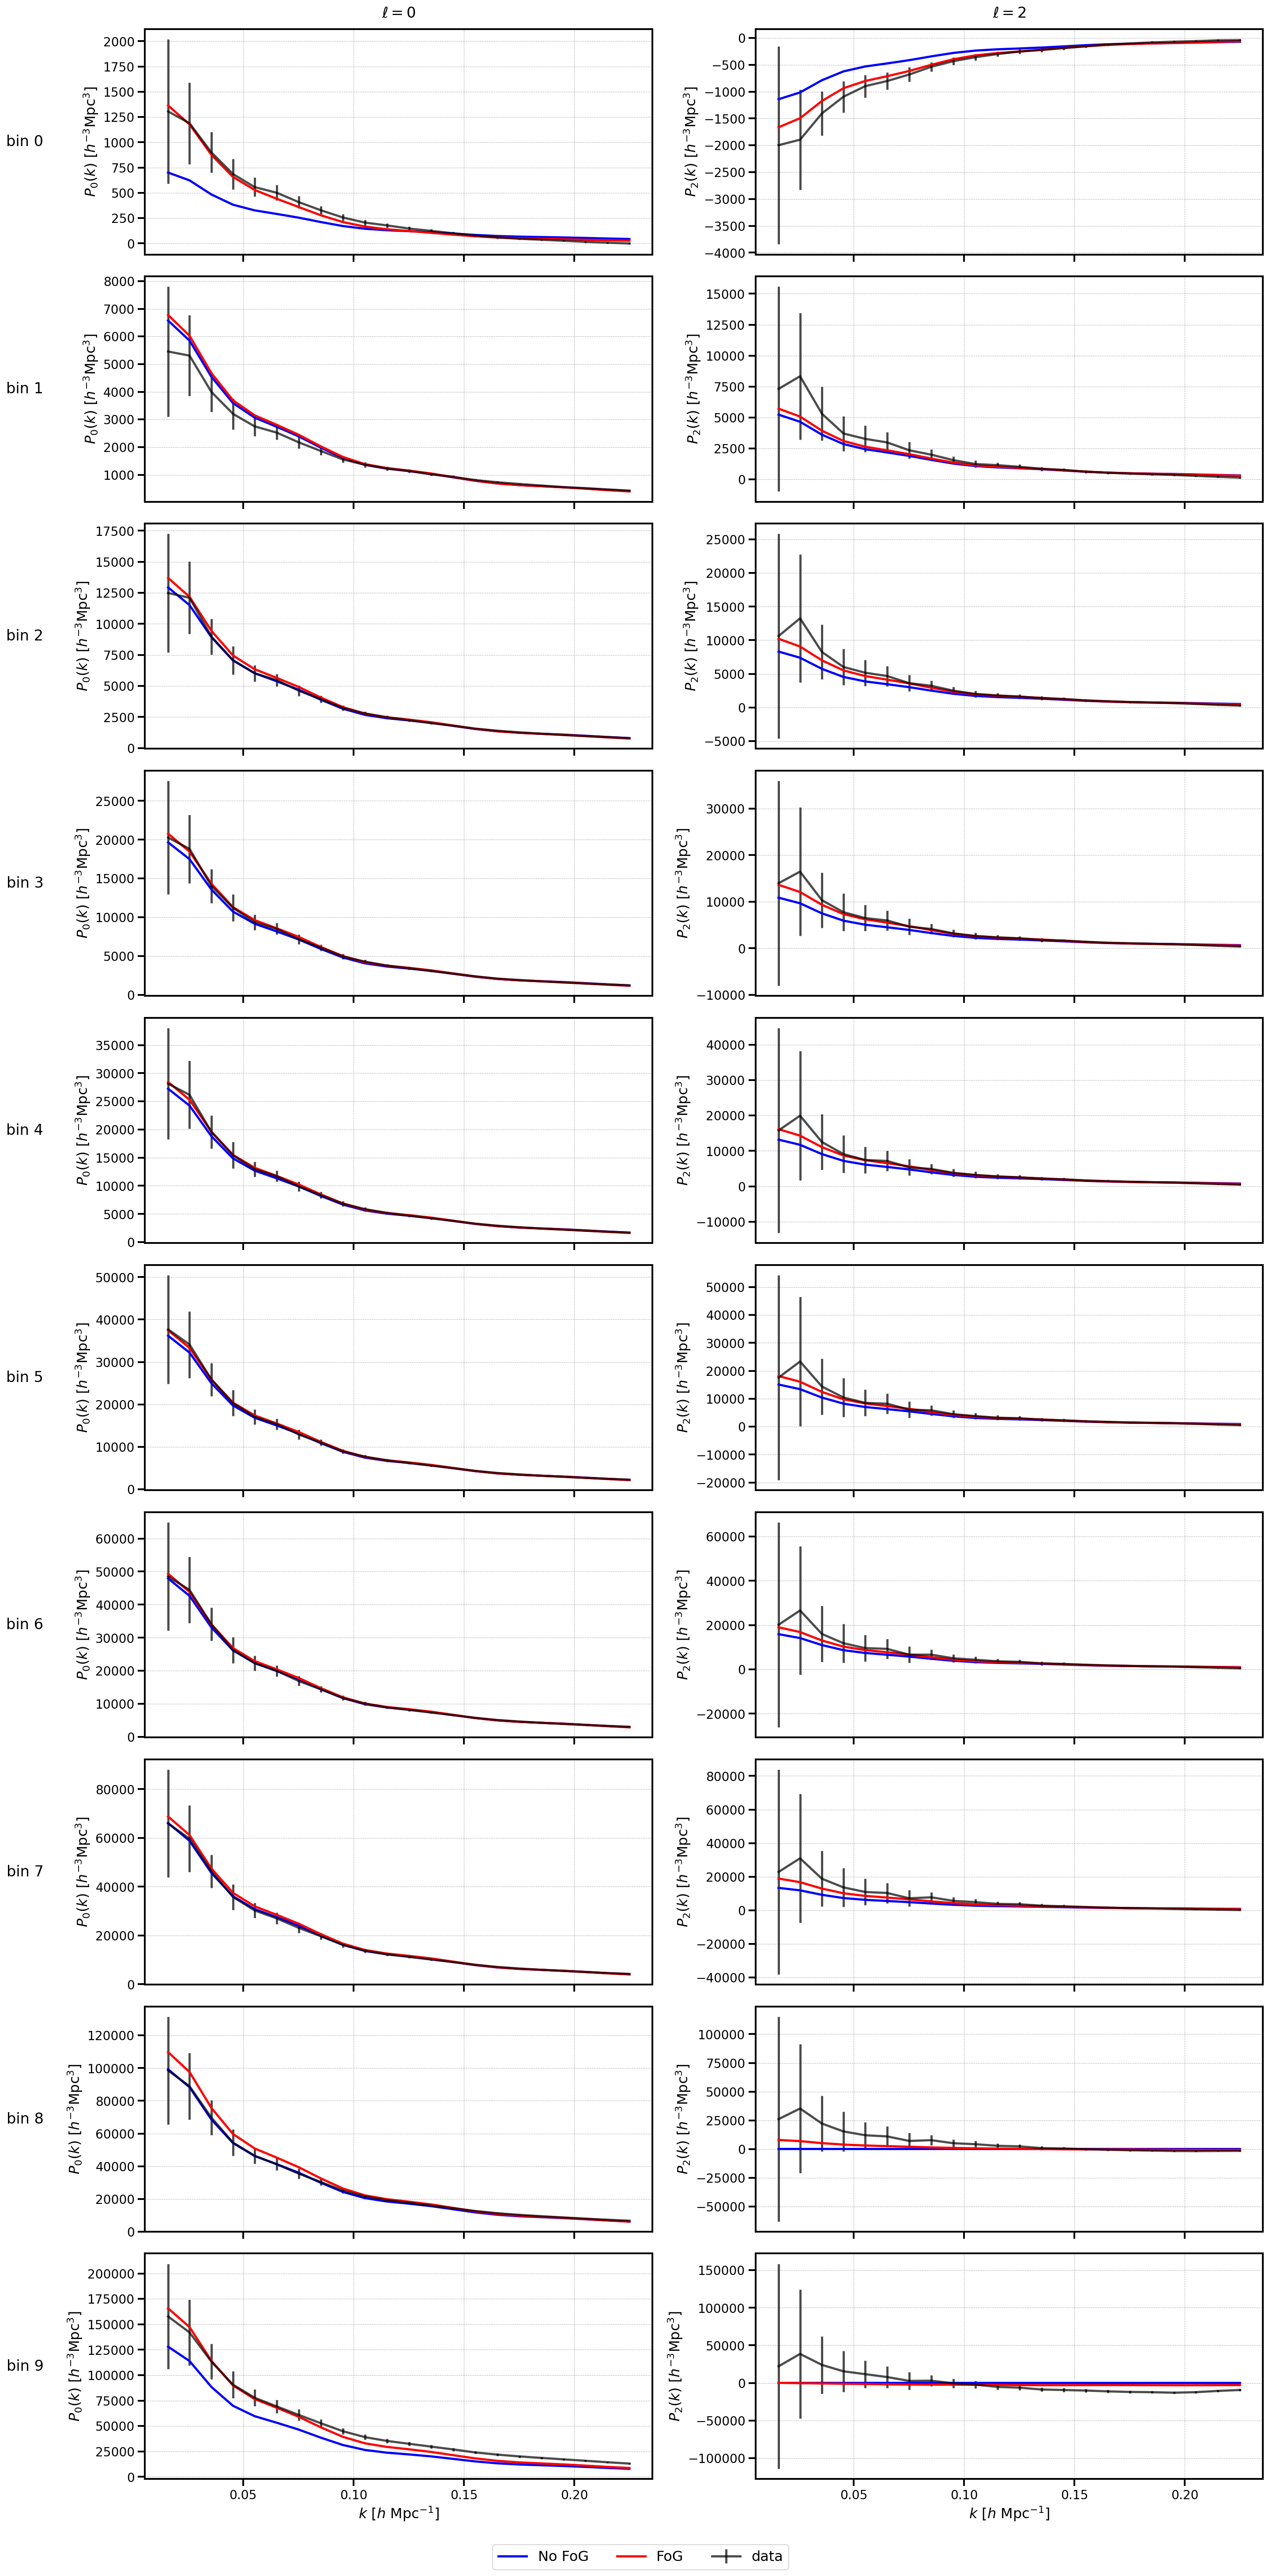

In [73]:
# plot data (with errors) and best fit Kaiser and damped Kaiser
fig, axs = plt.subplots(n_ptile, 2, figsize=(20,40), sharex=True) 

for i in range(n_ptile):
    theta, theta_damped = [b1[i][-1], beta[i][-1]], [b1_damped[i][-1], beta_damped[i][-1], sigma_damped[i][-1]]
    theta_damped = [b1_damped[i][-1], beta_damped[i][-1], sigma_damped[i][-1]]
    kaiser = Kaiser(theta)
    kaiser_damped = Kaiser_damped(theta_damped)
    
    # get diagonals of inverse covarinace matrix as errors on data
    cov_mat = np.loadtxt('/home/jwack/main/bruteforce_covmat/covariance_matricies/cov_ptile_%d.txt'%i)
    cov_mat_sliced = icf.slice_covmat(cov_mat, k_full, kmax)
    errs = np.sqrt(np.diagonal(cov_mat_sliced).reshape((2,-1)))
    
    for l, ell in enumerate(ells):
        axs[i][l].errorbar(k, Pk_ells[i][l], yerr=errs[l] ,c='k', alpha=0.7, label='data')
        axs[i][l].plot(k, kaiser[l], c='blue',label='No FoG')
        axs[i][l].plot(k, kaiser_damped[l], c='red', label='FoG')
        
        if i == 9:
            axs[i][l].set_xlabel(r'$k$ [$h \ \mathrm{Mpc}^{-1}$]')
        axs[i][l].set_ylabel(r'$P_{%d}(k)$ [$h^{-3}\mathrm{Mpc}^3$]'%ell)
        
        
cols_txt = [r'$\ell=%d$'%ell for ell in ells]
rows_txt = [r'bin %d'%i for i in range(n_ptile)]

# xy is point to place text in terms of coordinate system xycoords
for ax, col_txt in zip(axs[0], cols_txt):
    ax.annotate(col_txt, xy=(0.5, 1.05), xycoords='axes fraction',
                size='large', ha='center', va='baseline')

for ax, row_txt in zip(axs[:,0], rows_txt):
    ax.annotate(row_txt, xy=(-0.2, 0.5), xycoords='axes fraction',
                size='large', ha='right', va='center')    
   

handles, labels = plt.gca().get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 0), ncol=n_ptile)
fig.tight_layout()

plt.show()
#fig.savefig('plots/data_fittedmodels_largesig.pdf')

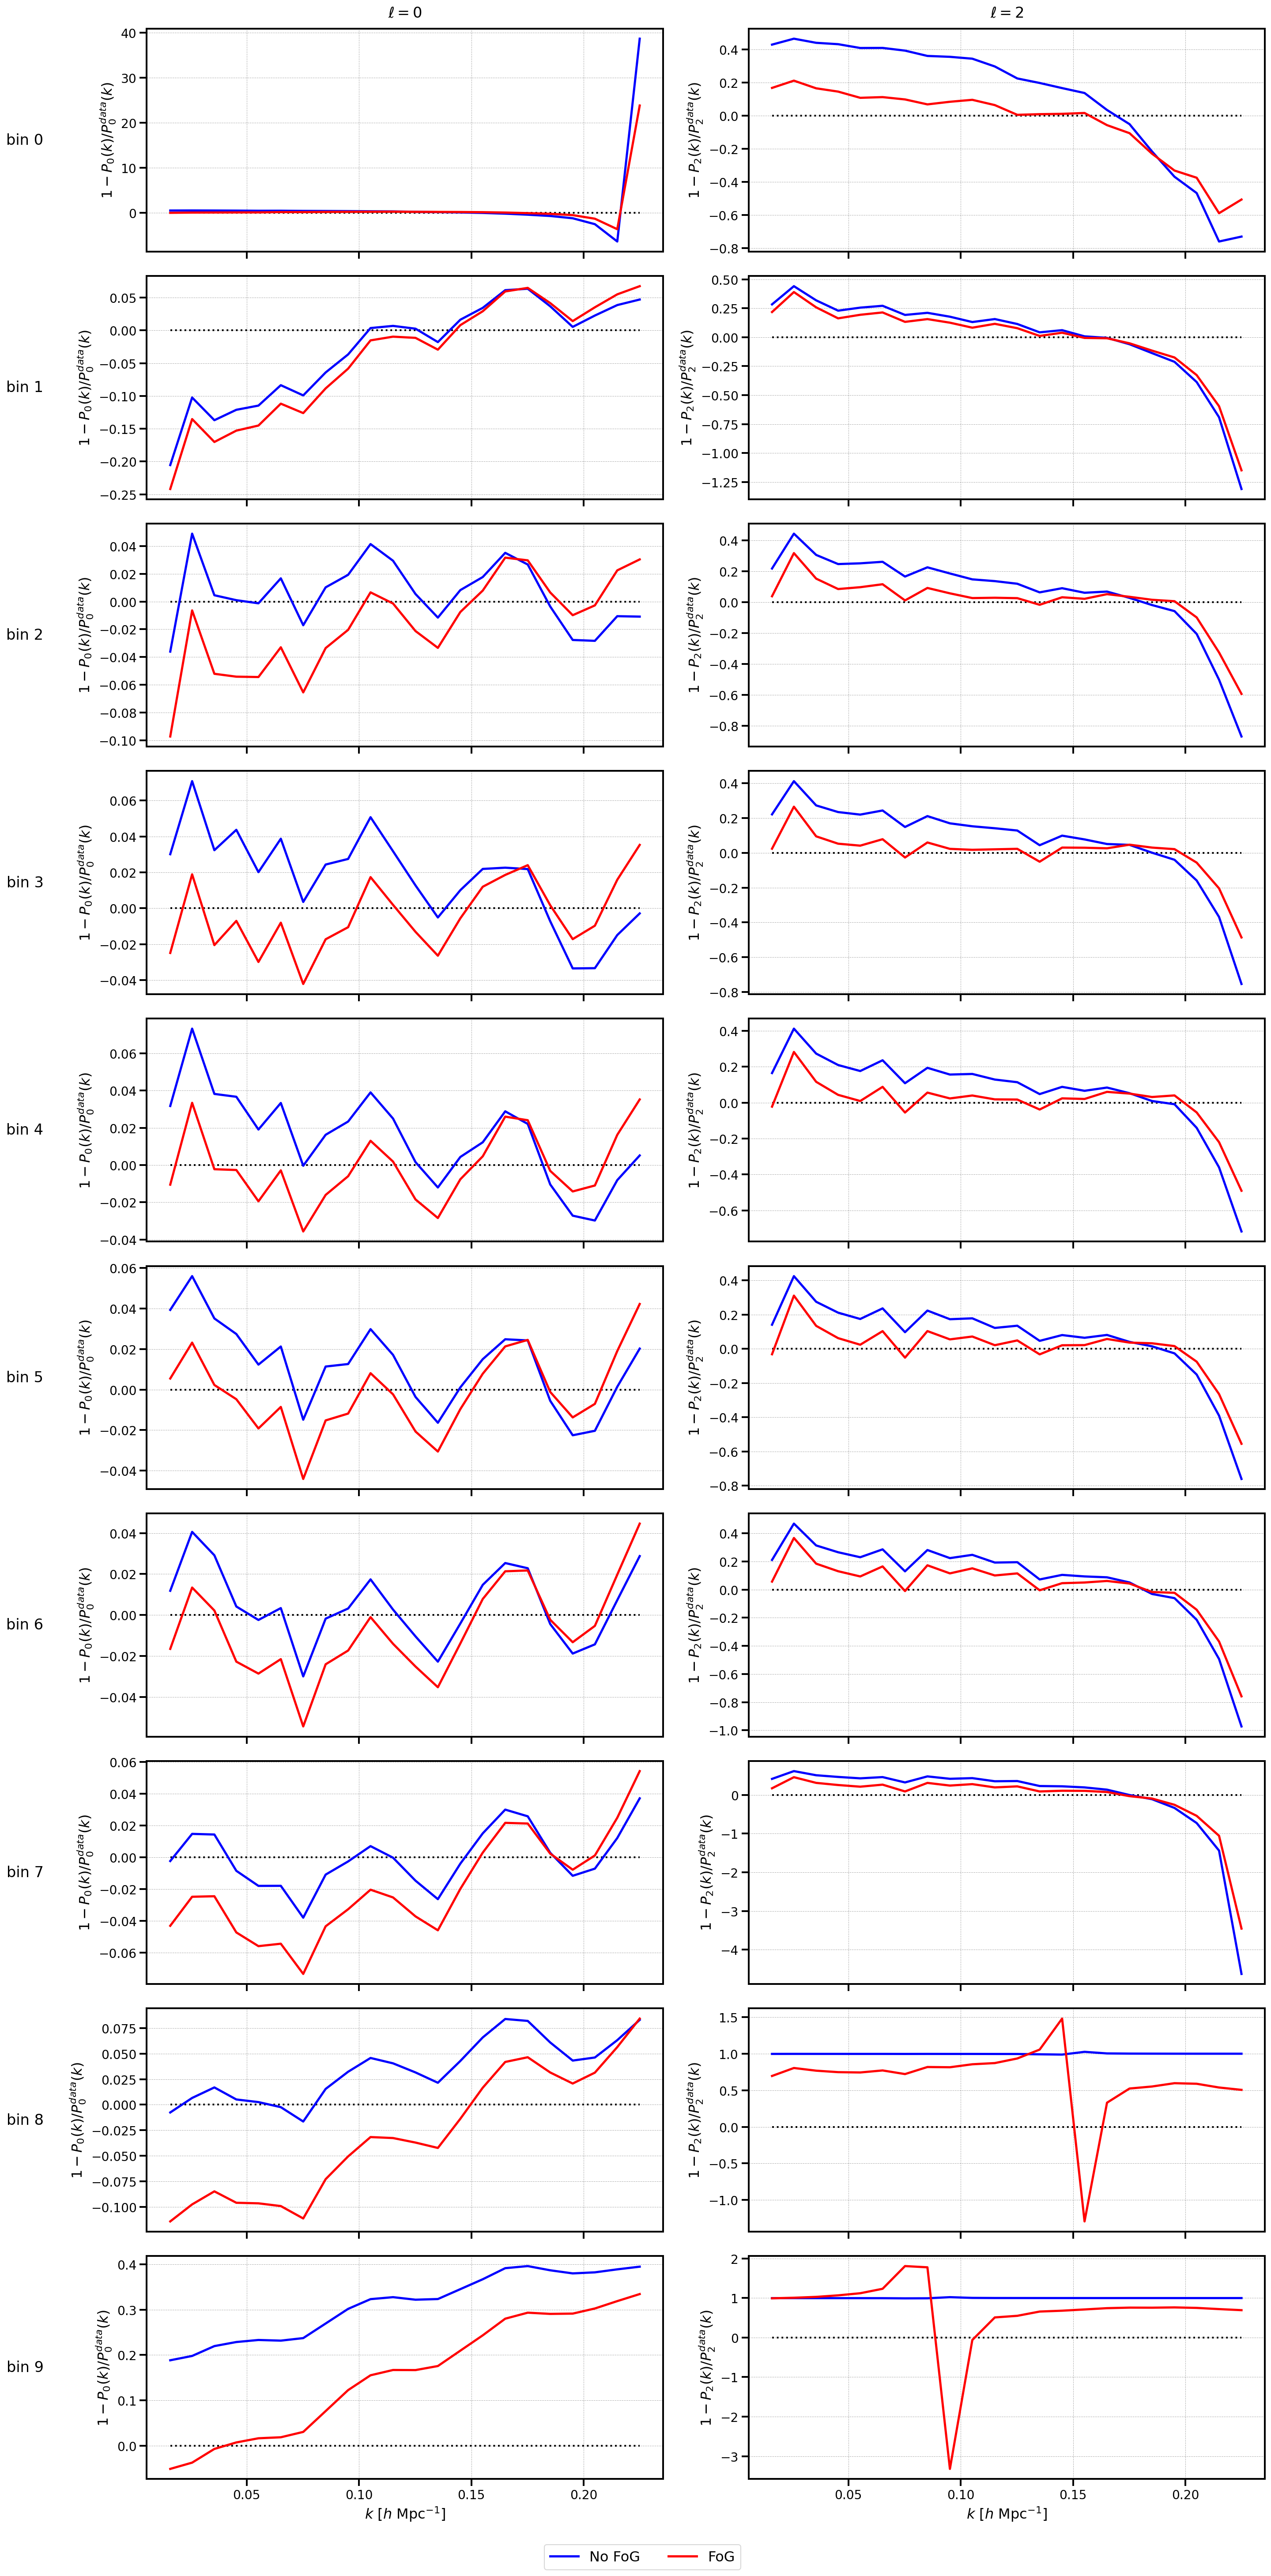

In [74]:
# plot relative error between data and models. 
fig, axs = plt.subplots(n_ptile, 2, figsize=(20,40), sharex=True) 

for i in range(n_ptile):
    theta, theta_damped = [b1[i][-1], beta[i][-1]], [b1_damped[i][-1], beta_damped[i][-1], sigma_damped[i][-1]]
    theta_damped = [b1_damped[i][-1], beta_damped[i][-1], sigma_damped[i][-1]]
    kaiser = Kaiser(theta)
    kaiser_damped = Kaiser_damped(theta_damped)
    
    for l, ell in enumerate(ells):
        axs[i][l].hlines(0, k[0], k[-1], linestyle='dotted', color='k', linewidth=2)
        axs[i][l].plot(k, 1-kaiser[l]/Pk_ells[i][l], c='blue',label='No FoG')
        axs[i][l].plot(k, 1-kaiser_damped[l]/Pk_ells[i][l], c='red', label='FoG')
        
        if i == 9:
            axs[i][l].set_xlabel(r'$k$ [$h \ \mathrm{Mpc}^{-1}$]')
        axs[i][l].set_ylabel(r'$1-P_{%d}(k)/P_{%d}^{data}(k)$'%(ell,ell))
        
    
cols_txt = [r'$\ell=%d$'%ell for ell in ells]
rows_txt = [r'bin %d'%i for i in range(n_ptile)]

# xy is point to place text in terms of coordinate system xycoords
for ax, col_txt in zip(axs[0], cols_txt):
    ax.annotate(col_txt, xy=(0.5, 1.05), xycoords='axes fraction',
                size='large', ha='center', va='baseline')

for ax, row_txt in zip(axs[:,0], rows_txt):
    ax.annotate(row_txt, xy=(-0.2, 0.5), xycoords='axes fraction',
                size='large', ha='right', va='center')

    
handles, labels = plt.gca().get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 0), ncol=n_ptile)
fig.tight_layout()

plt.show()
#fig.savefig('plots/data_fittedmodels_largesig_relerr.pdf')

### Interpretation
Note: Positive values indicate too much damping while negative ones indicate too little. Plotted indication line of zero error for easier comparison.

- General: Monopole has better agreement than quadrupole. Overall, prediction of both models similar which is no surprise at small k since the damping term is approximately 1 and the best-fit parameter values are similar too (see `pre-analyis_fit.ipynb`). Effect of FoG term is visible in quadrupole: each bin (excluding 8 and 9) has some $k^*$ after which both models over-predict significantly. The damping term linders this slightly. The effect of the FoG term in the monopole cannot be properly seen for $k<0.2$. However, at the high $k$ end both models suddenly under-predict the data and the FoG term intensifies this. Running the fit up to larger $k$ is needed to further investigate this. This would also help to further illustrate the effect in the quadrupole.  

    Expect error to become bigger for larger k as simple (linear) model is expected to only give accurate predictions on large scales. Visible for quadrupole with models significantly over-predicting this multipole at large k. For monopole only visible for high density bin (models under-predict; bins 7,8,9 increasingly steep), suggesting that the monopole prediction is more accurate than the quadrupole prediction. Hence, fit to larger $k$ to get more information about model performance.
    
- Monopole: Interesting features of both models in medium density regions: dips at $k \approx 0.075, 0.13$. Kaiser+FoG has tendency to under-predict, Kaiser to over-predict. Depending on the bin (and partially the $k$ range) one model outperforms the other with no clear trend.

    Large peak in bin 0 probably due to $\sigma$ hitting the upper prior bound 
    
- Quadrupole: Kaiser+FoG seems to outperform Kaiser across all densities and k.

    Bins 8, 9: Kaiser prediction is of order $10$ and thus much smaller than the data multipole. Hence the relative error is $1$. For Kaiser+FoG, the prediction is also small and positive at small $k$ but turns increasingly negative while the data quadrupole is still positive causing a relative error bigger than $1$. As $k$ in creases, the data quadrupole also turns negative, but while transitioning from positive to negative values the magnitude becomes small and since we divide by it , the relative error becomes large.
    
- $\ell=0$: From `pre-analysis_fit.ipynb` we know that for this bin $sigma$ becomes very large for $k>0.12$. When restricting $\sigma$ through its prior to be be smaller than $5$, that value is attained quickly when $k>0.12$, causing the two model predictions to be very similar. Allowing for much greater $\sigma$ improves the agreement with the data significantly. The large error at the high end limit of $k$ is due to the same reason as explained in $\ell=2$, bins 8 and 9 (data changes sign and is thus small.) 

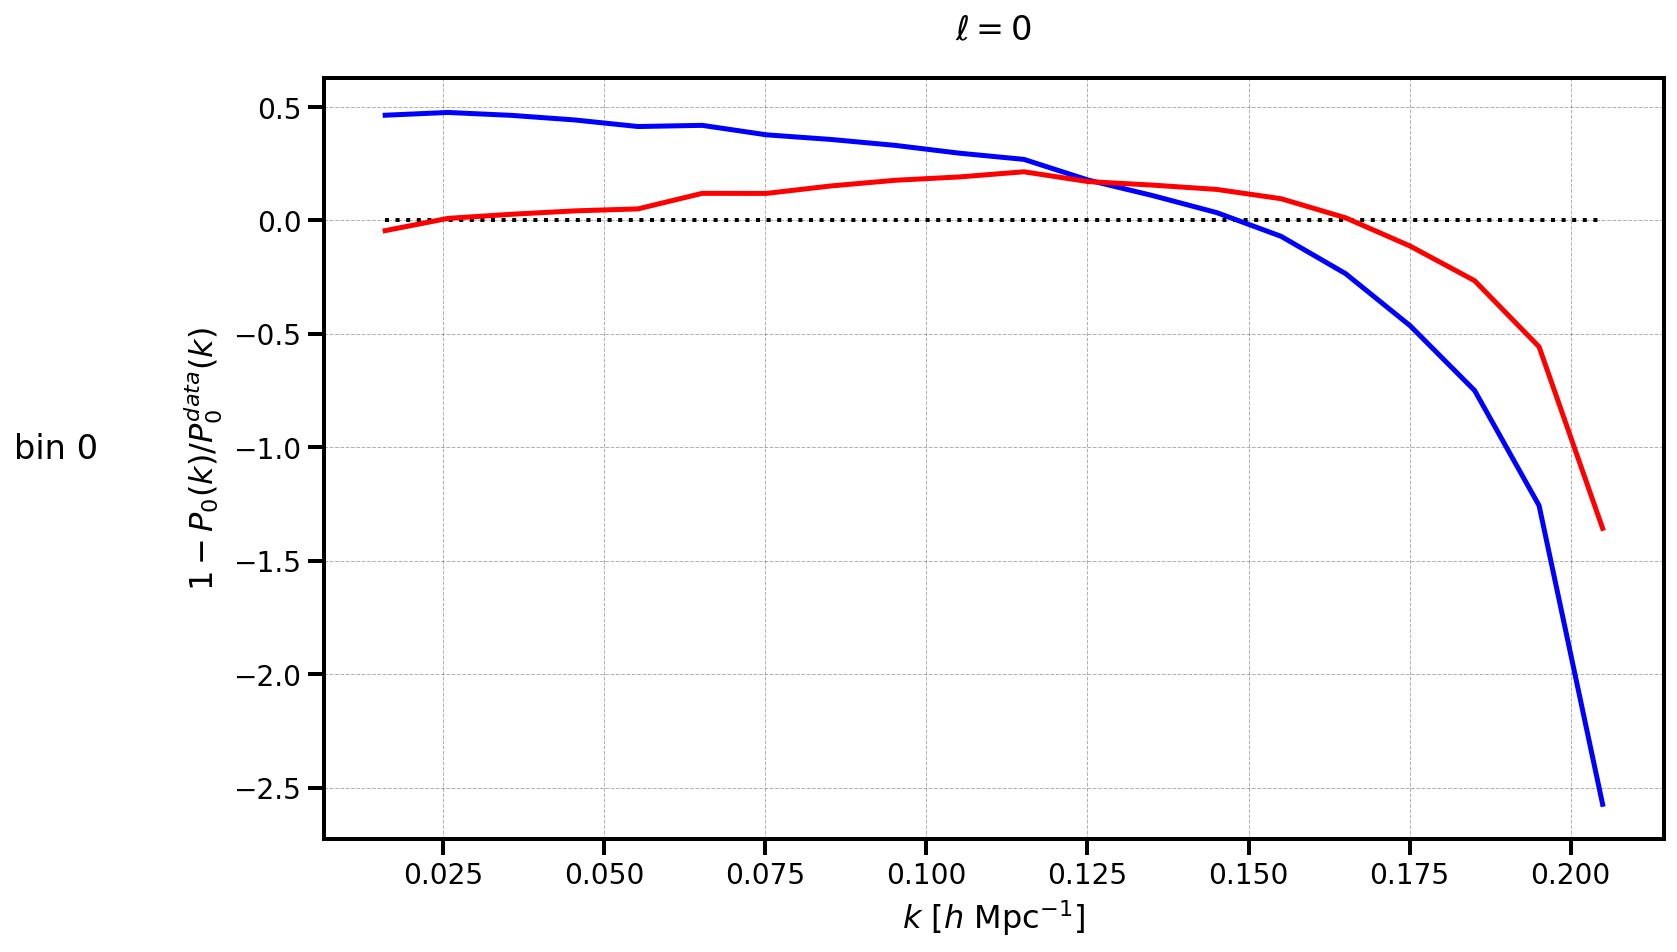

In [72]:
# remake bin 0 ell=0 plot for better visibility
fig = plt.figure()
ax = plt.gca()

i = 0
theta, theta_damped = [b1[i][-1], beta[i][-1]], [b1_damped[i][-1], beta_damped[i][-1], sigma_damped[i][-1]]
theta_damped = [b1_damped[i][-1], beta_damped[i][-1], sigma_damped[i][-1]]
kaiser = Kaiser(theta)
kaiser_damped = Kaiser_damped(theta_damped)

slice_idx = -2

ax.hlines(0, k[0], k[:slice_idx][-1], linestyle='dotted', color='k', linewidth=2)
ax.plot(k[:slice_idx], (1-kaiser[0]/Pk_ells[0][0])[:slice_idx], c='blue',label='No FoG')
ax.plot(k[:slice_idx], (1-kaiser_damped[0]/Pk_ells[0][0])[:slice_idx], c='red', label='FoG')

ax.set_xlabel(r'$k$ [$h \ \mathrm{Mpc}^{-1}$]')
ax.set_ylabel(r'$1-P_{%d}(k)/P_{%d}^{data}(k)$'%(0,0))

ax.annotate(r'$\ell=0$', xy=(0.5, 1.05), xycoords='axes fraction',
                size='large', ha='center', va='baseline')
ax.annotate(r'bin 0', xy=(-0.2, 0.5), xycoords='axes fraction',
                size='large', ha='center', va='baseline')

plt.show()